<a href="https://colab.research.google.com/github/nuriyeakin/yolo_from_scratch/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7133255579661776529, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13861772597871954745
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
from google.colab import files #model.py
src = list(files.upload().values())[0]
open('mylib_2.py','wb').write(src)
import mylib_2

Saving model.py to model.py
torch.Size([2, 1470])


In [4]:
from google.colab import files #dataset
src = list(files.upload().values())[0]
open('mylib_3.py','wb').write(src)
import mylib_3

Saving dataset.py to dataset.py


In [5]:
from google.colab import files #utils
src = list(files.upload().values())[0]
open('mylib_4.py','wb').write(src)
import mylib_4

Saving utils.py to utils.py


In [6]:
from google.colab import files #loss
src = list(files.upload().values())[0]
open('mylib_5.py','wb').write(src)
import mylib_5

Saving loss.py to loss.py


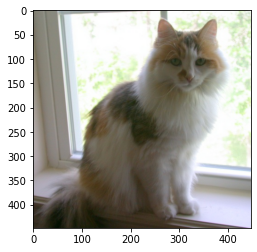

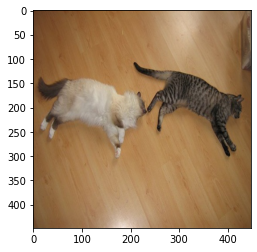

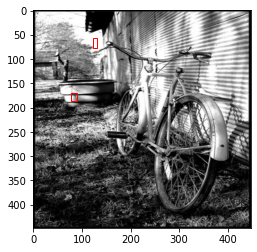

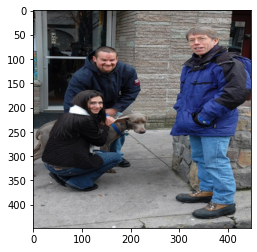

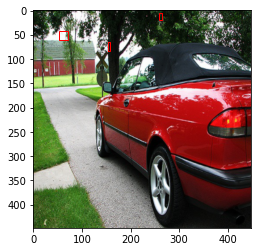

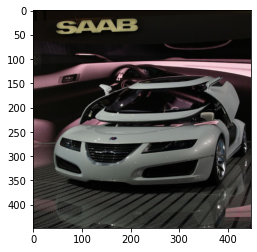

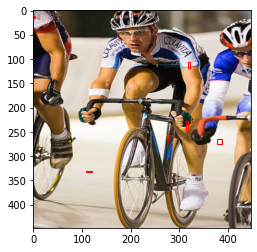

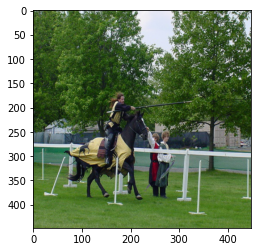

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT #resim transformları için 
from tqdm import tqdm  #progressbar için 

from torch.utils.data import DataLoader
from model import Yolov1
from dataset import VOCDataset
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import YoloLoss

seed = 123
torch.manual_seed(seed) #same datasets loading

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0 #sadece bir batchte train yapmak için 0 dedik yani regularizasyon yapmıyoruz
EPOCHS = 1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "/content/drive/MyDrive/YOLO 5 adım/archive/best.pt" #over fit olan modeli aldık
IMG_DIR = "/content/drive/MyDrive/YOLO 5 adım/archive/images" 
LABEL_DIR = "/content/drive/MyDrive/YOLO 5 adım/archive/labels"


class Compose(object): #buradaki neden, göndereceğimiz dönüşümümüzün yalnızca resim üzerinde işlemesi çünkü sadece resize yapıyoruz
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),]) #resize yapıp tensöre çevirdik


def train_fn(train_loader, model, optimizer, loss_fn): #tüm datasette bir training döngüsü olacak
    loop = tqdm(train_loader, leave=True) #progressbar videosunda varmış
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar progress barda her batchteki lossu göreceğiz
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer) #bir model kaydettiysek bakıyor burası

    train_dataset = VOCDataset(
        "/content/drive/MyDrive/YOLO 5 adım/archive/8examples.csv", #eğer tüm dataseti istiyorsak train.csv yaparız biz burada 100 örnek aldık sadece
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset( #test kısmı
        "/content/drive/MyDrive/YOLO 5 adım/archive/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,#8 tanede denerken burayı false yaptık eğer çok az örnekte deniyorsak false fazla örnekte deniyorsak true yapıyoruz. çok az örnek yani tek bir batchte gerçeklesen örnekse false
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True, 
    )

  
    for epoch in range(EPOCHS):
        for x, y in train_loader:  #BU KISIM GÖRSELLEŞTİRME İÇİN SONUCU BİZE GÖSTERİYOR TEK TEK RESİMLERDE
            x = x.to(DEVICE)              #Bu kısmı uygularken yukarıda hiperparametreler kısmındaki LOAD_MODAL'ı True yapmamız gerekiyor.
            for idx in range(8):
                bboxes = cellboxes_to_boxes(model(x))
                bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
                plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            import sys
            sys.exit()

        pred_boxes, target_boxes = get_bboxes( train_loader, model, iou_threshold=0.5, threshold=0.4 )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}") #her epoch için yazdırdık

        if mean_avg_prec > 0.9:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)   #kaydetmek için buu
            import time
            time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()